## Setup + Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'

In [3]:
!unzip -qo "{dataset_path}" -d "./dataset"

In [4]:
# installing dependencies
!pip install -q "transformers[torch]==4.38.2" accelerate
!pip install -q datasets evaluate

# for augmentations
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [5]:
import os
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from transformers import Trainer, TrainingArguments
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import PIL.Image as Img
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import shutil
import albumentations as A
from uuid import uuid4

## Data Analysis

In [6]:
#del data

In [7]:
data = pd.read_csv('dataset/Training.csv')

In [8]:
data.Image = data.Image.map(lambda x: f'dataset/Training Images/{x}')

In [9]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,MildDemented
1,dataset/Training Images/mildDem1.jpg,MildDemented
2,dataset/Training Images/mildDem10.jpg,MildDemented
3,dataset/Training Images/mildDem100.jpg,MildDemented
4,dataset/Training Images/mildDem101.jpg,MildDemented
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,VeryMildDemented
5117,dataset/Training Images/verymildDem996.jpg,VeryMildDemented
5118,dataset/Training Images/verymildDem997.jpg,VeryMildDemented
5119,dataset/Training Images/verymildDem998.jpg,VeryMildDemented


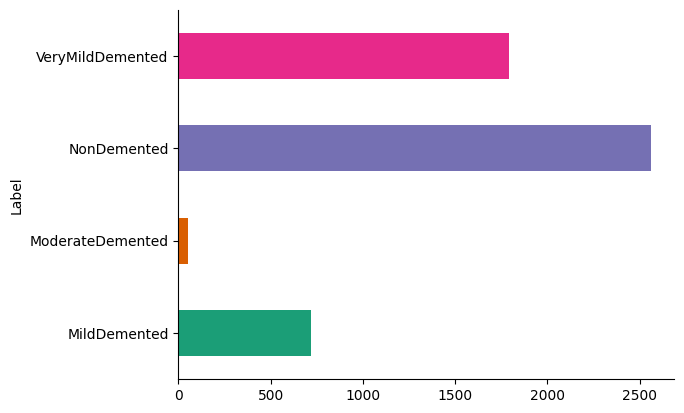

In [10]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Image path: dataset/Training Images/verymildDem159.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem1753.jpg
Label: NonDemented
Image path: dataset/Training Images/nonDem2142.jpg
Label: NonDemented
Image path: dataset/Training Images/verymildDem1623.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/verymildDem1328.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem2133.jpg
Label: NonDemented


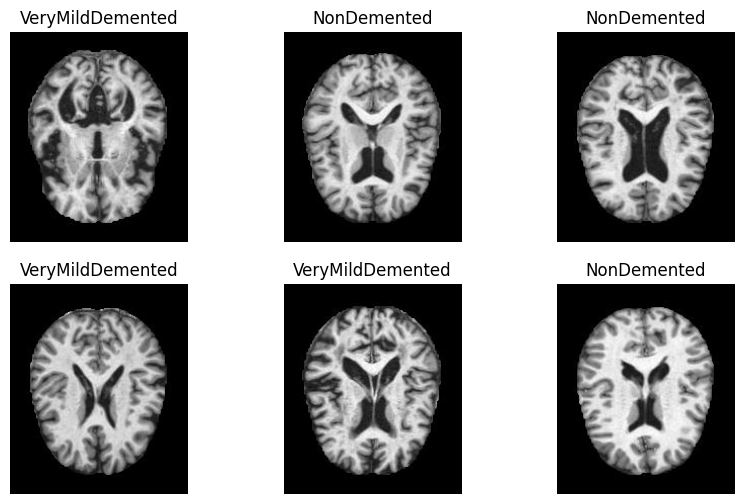

In [11]:
# Plotting random samples
plt.figure(figsize=(10, 6))

for i, idx in enumerate(np.random.choice(len(data), 6)):
    im_path = data.loc[idx, 'Image']  # Ensure this is the correct column name for the image paths
    label = data.loc[idx, 'Label']    # Ensure this is the correct column name for the labels

    print("Image path:", im_path)
    print("Label:", label)


    # Read the image using cv2
    img = cv2.imread(im_path)
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Training Setup

In [12]:
id2label = {str(i): c for i, c in enumerate(data.Label.unique())}
label2id = {c: str(i) for i, c in id2label.items()}

id2label

{'0': 'MildDemented',
 '1': 'ModerateDemented',
 '2': 'NonDemented',
 '3': 'VeryMildDemented'}

In [13]:
data.Label = data.Label.map(lambda x: int(label2id[x]))

In [14]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [15]:
image_counts = data['Label'].value_counts()

# Print the number of images for each label
print(image_counts)

Label
2    2560
3    1792
0     717
1      52
Name: count, dtype: int64


In [16]:
data_limited = pd.DataFrame()  # Create an empty DataFrame to hold the limited set
for label in [2, 3]:
    data_subset = data[data['Label'] == label]
    # Sample 1000 images without replacement
    data_subset_sampled = data_subset.sample(n=1000, random_state=42)
    data_limited = pd.concat([data_limited, data_subset_sampled])

# For labels not in [2, 3], just append them as they are
data_other_labels = data[~data['Label'].isin([2, 3])]
data_limited = pd.concat([data_limited, data_other_labels])

In [17]:
data_limited

,Image,Label
2925,dataset/Training Images/nonDem635.jpg,2
2506,dataset/Training Images/nonDem258.jpg,2
1942,dataset/Training Images/nonDem2053.jpg,2
1247,dataset/Training Images/nonDem1428.jpg,2
2125,dataset/Training Images/nonDem2218.jpg,2
...,...,...
764,dataset/Training Images/moderateDem51.jpg,1
765,dataset/Training Images/moderateDem6.jpg,1
766,dataset/Training Images/moderateDem7.jpg,1
767,dataset/Training Images/moderateDem8.jpg,1


In [18]:
image_counts = data_limited['Label'].value_counts()

# Print the number of images for each label
print(image_counts)

Label
2    1000
3    1000
0     717
1      52
Name: count, dtype: int64


In [19]:
test = pd.DataFrame()
test = data
data = data_limited.reset_index(drop=True)


In [20]:
image_counts = data['Label'].value_counts()

# Print the number of images for each label
print(image_counts)

Label
2    1000
3    1000
0     717
1      52
Name: count, dtype: int64


In [21]:
#Code to delete augmentation folder

#import shutil

#dir = '/content/augmented_dataset'
#shutil.rmtree(dir)

In [22]:
# train val split
# train, val = train_test_split(data, random_state=20, train_size=0.8, stratify=data.Label)

In [23]:
# #data augmentation attempt # 1

# import tensorflow as tf
# from datasets import load_dataset, Features, ClassLabel, Image, DatasetDict
# from PIL import Image as PILImage
# import io

# # Function to load an image from its path and apply data augmentation
# def augment(example):
#     # Load the image from disk
#     image = PILImage.open(example['Image'])
#     image = image.convert('RGB')  # Ensure image is in RGB format
#     image = tf.image.convert_image_dtype(np.array(image), tf.float32)  # Convert to TensorFlow tensor

#     # Apply some data augmentation operations
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     # ... add more transformations as needed ...

#     # Convert image back to bytes and update the example
#     image = tf.image.encode_jpeg(tf.cast(image * 255, tf.uint8)).numpy()
#     example['Image'] = image

#     return example

# # Map the augmentation function to the training dataset
# augmented_train_dataset = dataset['train'].map(augment)

# # Now you have an augmented training dataset
# print(augmented_train_dataset)


In [24]:
import albumentations as A
import cv2
import numpy as np
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
from uuid import uuid4

# Assuming `data` is your DataFrame and `id2label` is a dictionary mapping ids to labels

# Create the respective folders
!rm -rf augmented_dataset
for id in id2label.keys():
    !mkdir -p augmented_dataset/{id}

# Define your custom rotation function
transform2 = lambda x, y: (F.rotate(T.ToTensor()(x), y).permute(1, 2, 0).numpy() * 255).astype(np.uint8)

# Define a function for brightness and contrast adjustment
def adjust_brightness_contrast(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(),
    ])
    return transform(image=image)['image']

# Function to perform rotation augmentation
def rotate_image(image):
    # Increase the rotation limit for more variance
    return A.Rotate(limit=(-180, 180), p=1)(image=image)['image']

# Transform samples
for _, row in data.iterrows():
    img_path, label = row['Image'], row['Label']

    #print(img_path)
    #print(label)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at {img_path}")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_name = str(uuid4())
        cv2.imwrite(f'augmented_dataset/{label}/{img_name}_0.png', img)

        # for i in range(-90, 90, 9):  # Adjust the range and step as per your requirement
        #     # Apply rotation
        #     rotated_img = transform2(img, i)
        #     # Apply brightness and contrast adjustment
        #     final_img = adjust_brightness_contrast(rotated_img)

        #     cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i+91}.png', final_img)  # i+21 to avoid negative indices

        # augmentations
        # clahe
        if label == 1: #only if label is moderately demented
          for i in range(10):  # Create 10 augmented images
              # Apply brightness and contrast adjustment
              augmented_img = adjust_brightness_contrast(img)
              # Apply the increased rotation
              augmented_img = rotate_image(augmented_img)
              # Save the augmented image
              cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i+1}.png', augmented_img)


In [25]:
# Old Augmentation pipeline
"""
# Create the respective folders
!rm -rf augmented_dataset

for id in id2label.keys():
  !mkdir -p augmented_dataset/{id}

# transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.RandomRotate90(),
])

# transform samples
# for each image, create 10 more transformed images
for _, row in data.iterrows():
  img_path, label = row.Image, row.Label

  print(img_path)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img_name = str(uuid4())
  cv2.imwrite(f'augmented_dataset/{label}/{img_name}_0.png', img)

  for i in range(1, 11):
    transformed_img = transform(image=img)["image"]
    cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i}.png', transformed_img)"""

'\n# Create the respective folders\n!rm -rf augmented_dataset\n\nfor id in id2label.keys():\n  !mkdir -p augmented_dataset/{id}\n\n# transformations\ntransform = A.Compose([\n    A.HorizontalFlip(p=0.5),\n    A.VerticalFlip(p=0.5),\n    A.RandomBrightnessContrast(),\n    A.RandomRotate90(),\n])\n\n# transform samples\n# for each image, create 10 more transformed images\nfor _, row in data.iterrows():\n  img_path, label = row.Image, row.Label\n\n  print(img_path)\n  img = cv2.imread(img_path)\n  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n  img_name = str(uuid4())\n  cv2.imwrite(f\'augmented_dataset/{label}/{img_name}_0.png\', img)\n\n  for i in range(1, 11):\n    transformed_img = transform(image=img)["image"]\n    cv2.imwrite(f\'augmented_dataset/{label}/{img_name}_{i}.png\', transformed_img)'

In [26]:
dataset = load_dataset('imagefolder', data_dir='augmented_dataset')['train'].train_test_split(0.2)
dataset

Resolving data files:   0%|          | 0/3289 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2631
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 658
    })
})

In [27]:
#model_name = "google/vit-base-patch16-224-in21k"
model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"

In [28]:
#processor = ViTImageProcessor.from_pretrained(model_name)
processor = BeitImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
# def transform(batch):
#   inputs = processor([Img.open(x).convert('RGB') for x in batch['Image']], return_tensors='pt', device=device)
#   inputs['label'] = batch['Label']

#   return inputs

def transform(batch):
  inputs = processor(batch['image'], return_tensors='pt')
  inputs['label'] = batch['label']

  return inputs

def collate(batch):
  return {
    'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
    'labels': torch.tensor([x['label'] for x in batch])
  }


accuracy = evaluate.load("accuracy")
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [31]:
from evaluate import load

# Load metrics
f1_metric = load("f1")
accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Calculate F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    # Calculate accuracy
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


In [32]:
prepared_dataset = dataset.with_transform(transform)

#prepared_dataset = train_data_augmented.with_transform(transform)
print(prepared_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2631
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 658
    })
})


In [33]:
# # UMER BeiT model extraction
# # will not run
# from transformers import BEiTModel, ViTFeatureExtractor
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model

# # Load pre-trained BEiT model
# model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"
# beit_model = BEiTModel.from_pretrained(model_name)

# # Load feature extractor
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# # Create a new model with a classification head
# input_shape = (224, 224, 3)  # Set the input shape
# inputs = tf.keras.Input(shape=input_shape)

# # Preprocess the input and prepare for BEiT model
# processed_inputs = feature_extractor(inputs, return_tensors="np").pixel_values
# processed_inputs = tf.transpose(processed_inputs, [0, 2, 3, 1])  # Rearrange to TensorFlow's data format

# # Extract features using BEiT model (you might need to adapt this for TensorFlow)
# outputs = beit_model(processed_inputs)

# # Add custom layers on top of BEiT
# x = GlobalAveragePooling2D()(outputs.last_hidden_state)
# x = Dense(2, activation='softmax')(x)  # Use 'sigmoid' for binary classification

# # Construct the final model
# model = Model(inputs=inputs, outputs=x)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Now you can train the model using the `model.fit` method


In [34]:
model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
'''model = ViTForImageClassification.from_pretrained(
      model_name,
      num_labels=2,
      id2label=id2label,
      label2id=label2id,
      ignore_mismatched_sizes=True
    )'''

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'model = ViTForImageClassification.from_pretrained(\n      model_name,\n      num_labels=2,\n      id2label=id2label,\n      label2id=label2id,\n      ignore_mismatched_sizes=True\n    )'

In [35]:
model.to(device)
print()

In [36]:
# # image data augmentation attempt 2

# from datasets import load_dataset
# import numpy as np
# from PIL import Image
# import tensorflow as tf
# from transformers import AutoFeatureExtractor

# model_name = "google/vit-base-patch16-224-in21k"
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# # Define the augmentation function
# def augment_and_process(examples):
#     # Convert to PIL Image for augmentation
#     images = [Image.open(io.BytesIO(image)) for image in examples['Image']]
#     # Perform augmentation and preprocess
#     augmented_images = [feature_extractor(image=np.array(augment_image(image)), return_tensors="pt") for image in images]
#     # Extract pixel values
#     pixel_values = [item['pixel_values'][0] for item in augmented_images]
#     # Return the processed examples
#     examples['pixel_values'] = pixel_values
#     return examples

# # Perform the map operation and reassign the datasets
# prepared_dataset["train"] = prepared_dataset["train"].map(augment_and_process, batched=True, remove_columns=['Image'])

# # Update the data collator
# def collate(examples):
#     pixel_values = torch.stack([example['pixel_values'] for example in examples])
#     labels = torch.tensor([example['labels'] for example in examples], dtype=torch.long)
#     return {'pixel_values': pixel_values, 'labels': labels}




In [37]:
training_args = TrainingArguments(
  output_dir="./vit_output",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=5,
  fp16=True,
  logging_steps=12,
  learning_rate=1e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
  model=model,
  args=training_args,
  data_collator=collate,
  compute_metrics=compute_metrics,
  train_dataset=prepared_dataset["train"],
  eval_dataset=prepared_dataset["test"],
  tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [38]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.756800,0.678702,0.683891,0.686472
2,0.452100,0.510367,0.776596,0.775142
3,0.210200,0.439105,0.840426,0.838315
4,0.090500,0.324878,0.881459,0.880790
5,0.079200,0.335755,0.873860,0.873853


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 949008101GF
  train_loss               =      0.3994
  train_runtime            =  0:06:05.14
  train_samples_per_second =      36.027
  train_steps_per_second   =       2.259


In [39]:
metrics = trainer.evaluate(prepared_dataset['test'])

In [40]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI Project/beit_v2_ckpt_5.pth')

## Inference on TestSet

In [43]:
# inf_model = ViTForImageClassification.from_pretrained(model_name)

inf_model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
inf_model.to(device)
inf_model.load_state_dict(torch.load('/content/drive/MyDrive/AI Project/beit_v1_ckpt_3.pth'))

<All keys matched successfully>

## New approach to inference

In [45]:
import os
import pandas as pd

def create_image_csv(base_path, output_csv):
    if not os.path.exists(base_path):
        print(f"The specified base path does not exist: {base_path}")
        return

    labels_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    images_data = []

    for folder in labels_folders:
        folder_path = os.path.join(base_path, folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder, img_file)  # Using relative path with the folder name
            images_data.append({'Image': img_path, 'Label': folder})

    # Create a DataFrame and save to CSV
    df = pd.DataFrame(images_data)
    df.to_csv(output_csv, index=False)
    print(f"CSV created with {len(images_data)} entries.")

# Usage
create_image_csv('dataset/Testing Images', 'testing_images.csv')


CSV created with 1279 entries.


In [46]:
testset = pd.read_csv('testing_images.csv')
testset['Image'] = testset['Image'].map(lambda x: os.path.join('dataset/Testing Images', x))

testset.head()

,Image,Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,NonDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,NonDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented


In [47]:
pred = {}
for x in testset.Image:
  img = cv2.imread(x)
  inputs = processor([Img.open(x).convert('RGB')], return_tensors='pt', device=device).to(device)

  logits = inf_model(**inputs).logits
  predicted_label = logits.argmax(-1).item()

  pred[x] = id2label[str(predicted_label)]

In [48]:
predicted_df = pd.DataFrame(list(pred.items()), columns=['Image', 'Predicted Label'])
predicted_df.to_csv('predictions_output.csv', index=False)

In [49]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Load the predictions CSV
predictions_df = pd.read_csv('predictions_output.csv')

# Assuming original_df is already created and loaded as follows:
# original_df = pd.DataFrame(images_data) as from your directory scanning script


In [50]:
predictions_df

,Image,Predicted Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,VeryMildDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,VeryMildDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,MildDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented
...,...,...
1274,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented
1275,dataset/Testing Images/ModerateDemented/29.jpg,VeryMildDemented
1276,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented
1277,dataset/Testing Images/ModerateDemented/31 (2)...,MildDemented


In [51]:
base_path = 'dataset/Testing Images'
labels_folders = os.listdir(base_path)

# Create a list to hold image paths and their labels
test_images = []
for folder in labels_folders:
    folder_path = os.path.join(base_path, folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        test_images.append((img_path, folder))

# Create a DataFrame
original_df = pd.DataFrame(test_images, columns=['Image', 'Label'])

In [52]:
# Ensure that the image path is the full path in both DataFrames or adjust as necessary
# Merge the DataFrames on the image column
results_df = pd.merge(original_df, predictions_df, on='Image', how='left')

# Rename columns for clarity if necessary
results_df.columns = ['Image', 'Actual Label', 'Predicted Label']

print(results_df)


                                                  Image      Actual Label  \
0        dataset/Testing Images/NonDemented/26 (89).jpg       NonDemented   
1        dataset/Testing Images/NonDemented/32 (45).jpg       NonDemented   
2        dataset/Testing Images/NonDemented/26 (70).jpg       NonDemented   
3         dataset/Testing Images/NonDemented/27 (3).jpg       NonDemented   
4        dataset/Testing Images/NonDemented/30 (98).jpg       NonDemented   
...                                                 ...               ...   
1274     dataset/Testing Images/ModerateDemented/30.jpg  ModerateDemented   
1275     dataset/Testing Images/ModerateDemented/29.jpg  ModerateDemented   
1276  dataset/Testing Images/ModerateDemented/27 (2)...  ModerateDemented   
1277  dataset/Testing Images/ModerateDemented/31 (2)...  ModerateDemented   
1278  dataset/Testing Images/ModerateDemented/29 (2)...  ModerateDemented   

       Predicted Label  
0     VeryMildDemented  
1     VeryMildDemented  


In [53]:
results_df

,Image,Actual Label,Predicted Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,NonDemented,VeryMildDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented,VeryMildDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,NonDemented,MildDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented,NonDemented
...,...,...,...
1274,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented,ModerateDemented
1275,dataset/Testing Images/ModerateDemented/29.jpg,ModerateDemented,VeryMildDemented
1276,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented,ModerateDemented
1277,dataset/Testing Images/ModerateDemented/31 (2)...,ModerateDemented,MildDemented


In [54]:
# Map label names to a consistent set of integers if necessary
label2id = {'MildDemented':0,
 'ModerateDemented':1,
'NonDemented':2,
 'VeryMildDemented':3}

# Apply mapping
results_df['Actual ID'] = results_df['Actual Label'].map(label2id)
results_df['Predicted ID'] = results_df['Predicted Label'].map(label2id)

# Calculate F1 score and accuracy
accuracy = accuracy_score(results_df['Actual ID'], results_df['Predicted ID'])
f1 = f1_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')  # weighted for imbalanced classes

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.6442533229085223
F1 Score: 0.6496679358039302


In [55]:
results_df

,Image,Actual Label,Predicted Label,Actual ID,Predicted ID
0,dataset/Testing Images/NonDemented/26 (89).jpg,NonDemented,VeryMildDemented,2,3
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented,VeryMildDemented,2,3
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented,NonDemented,2,2
3,dataset/Testing Images/NonDemented/27 (3).jpg,NonDemented,MildDemented,2,0
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented,NonDemented,2,2
...,...,...,...,...,...
1274,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented,ModerateDemented,1,1
1275,dataset/Testing Images/ModerateDemented/29.jpg,ModerateDemented,VeryMildDemented,1,3
1276,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented,ModerateDemented,1,1
1277,dataset/Testing Images/ModerateDemented/31 (2)...,ModerateDemented,MildDemented,1,0


## Old Approaches (Ignore)

In [ ]:
df = pd.DataFrame({'Image': pred.keys(), 'Label': pred.values()})

In [ ]:
df.to_csv('output.csv')

In [ ]:
# # file modification to adhere to syntax of submission
# df_modified = pd.read_csv('output.csv')


# df_modified['Label'] = df_modified['Label'].replace({0: 'Normal', 1: 'Mitosis'})


# df_modified.to_csv('AIC-2408_submission.csv', index=False)

In [ ]:
# file modification to adhere to syntax of submission
df_modified = pd.read_csv('output.csv')


df_modified['Image'] = df_modified['Image'].apply(lambda x: x.split('/')[-1].replace('.jpg', ''))


df_modified.to_csv('AIC-2408_submission3.csv', index=False)


from google.colab import files
files.download('AIC-2408_submission3.csv')


In [ ]:
# #Haider
# normal = 0
# mitosis = 0

# for i in range(len(train_data)):
#   if(train_data['Label'][i] == "Normal"):
#     normal += 1
#   else:
#     mitosis += 1

# print("Normal: ", normal)
# print("Mitosis: ", mitosis)

# #Imbalanced dataset

In [ ]:
# #Haider
# test_data = pd.read_csv('dataset/Test.csv')
# train_data['Image'] = train_data['Image'].astype(str)
# train_data['Image'] = train_data['Image'].apply(lambda x: str(x) + '.jpg')

# test_data['Image'] = test_data['Image'].astype(str)
# test_data['Image'] = test_data['Image'].apply(lambda x: str(x) + '.jpg')

In [ ]:
# #Haider
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)
# batch_size = 32

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# validation_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory='dataset/Training Images/',
#     x_col='Image',
#     y_col='Label',
#     target_size=(300, 300),
#     batch_size=batch_size,
#     class_mode='binary'
# )

# validation_generator = train_datagen.flow_from_dataframe(
#     dataframe=val_df,
#     directory='dataset/Training Images/',
#     x_col='Image',
#     y_col='Label',
#     target_size=(300, 300),
#     batch_size=batch_size,
#     class_mode='binary'
# )

# test_generator = validation_datagen.flow_from_dataframe(
#     dataframe=test_data,
#     directory='dataset/Testing Images/',
#     x_col='Image',
#     y_col=None,
#     target_size=(300, 300),
#     batch_size=batch_size,
#     class_mode=None,
#     shuffle=False
# )